In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [3]:
%reload_ext Cython

In [4]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [6]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [40]:
%config Completer.use_jedi = False

In [8]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
controls2  = controls[controls['HasPast'] == 1].reset_index(drop = True)
pmpm =pd.read_pickle(pp_str+'pmpm.p')
del controls

### 1. How many CC Codes change events for a random patient in a year (one event can have multiple changes at a time)

In [214]:
pmpm.PERS_ID.unique().size, pmpm.MYR.unique().size, pmpm.MYR.min(), pmpm.MYR.max(), pmpm.shape

(356446, 55, 201701, 202107, (9650961, 91))

In [21]:
bad_id = '-3'
record_counts_of_each_patient = pmpm.query("PERS_ID>@bad_id").groupby('PERS_ID').count().MYR
record_counts_of_each_patient = pd.DataFrame(record_counts_of_each_patient).reset_index().rename(columns={"MYR":"Count"})

In [327]:
num_sample = 1000
num_record = 55
sample = record_counts_of_each_patient.query("Count==@num_record").sample(n=num_sample)
print(f"Number of total patients who has records: {record_counts_of_each_patient.query('Count==@num_record').shape[0]}")
print(f"We take a Sample size: {sample.shape[0]}")

Number of total patients who has records: 44406
We take a Sample size: 1000


<AxesSubplot:ylabel='Frequency'>

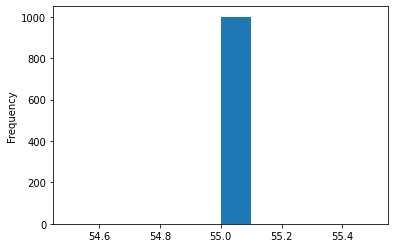

In [328]:
sample.Count.plot(kind="hist")

In [329]:
cc_records_organized = pmpm[pmpm.PERS_ID.isin(sample.PERS_ID)].sort_values(by=['PERS_ID','MYR']).set_index(['PERS_ID','MYR']).loc[:,'CC_ADHD':'CC_VISUAL_IMPAIR']
index = cc_records_organized.index
cc_records_diff = cc_records_organized.reset_index().groupby("PERS_ID").diff().iloc[:,1:].set_index(index)

In [330]:
test = cc_records_diff[cc_records_diff!=0].dropna(thresh=1)[['CC_DX_CNT']].reset_index()

In [331]:
test.groupby(pd.cut(test.MYR, bins=[201701, 201712, 201812, 201912, 202012, 202107])).count()

PERS_ID   MYR  CC_DX_CNT
MYR                                       
(201701, 201712]     1974  1974       1866
(201712, 201812]     2191  2191       2071
(201812, 201912]     2308  2308       2162
(201912, 202012]     2313  2313       2182
(202012, 202107]     1313  1313       1236